<a href="https://colab.research.google.com/github/dxvsh/LearningPytorch/blob/main/Week4/DLP_GA4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DLP GA4

**Common Data**


Assume that we want to continue pertaining a model containing 7 billion parameters with a context length of 2048 and the embedding dimension (model dimension) of 2048. The dataset contains 1 million samples (the size of each sample is exactly equal to the context length of the model). Suppose we set “per device batch size” to 16 and the gradient accumulation steps to 4.

**Q1.** How many iterations does it take to complete 1 epoch in a single GPU setting?

According to the docs:
> `gradient_accumulation_steps` — Number of updates steps to accumulate the gradients for, before performing a backward/update pass.

- The `per_device_batch_size` is 16. This means that during each iteration, the GPU processes 16 samples from the dataset.

- The `gradient_accumulation_steps` is set to 4.

- So, the effective batch size becomes: $16*4 = 64$, and **during each parameter update**, the model ***effectively*** processes **64 samples** instead of just updating updating the parameters after seeing 16 samples.

The number of iterations per epoch is then:

$$  \frac{\text{Total number of samples}}{\text{Effective batch size}}  $$


In [2]:
num_samples = 1e6
batch_size = 16
gradient_accumulation_steps = 4

effective_batch_size = batch_size * gradient_accumulation_steps

iterations_per_epoch = num_samples / effective_batch_size
iterations_per_epoch

15625.0

It takes 15625 iterations to complete 1 epoch (one full pass over the 1M samples)

**Q2.** The statement that the weight update happens at the end of one epoch is
- [ ] True
- [x] False


As we saw above, the weights actually get updated after processing 4 batches (64 samples in total) since the `gradient_accumulation_steps` is set to 4. The gradients are accumulated for 4 steps (or batches, and each batch has 16 samples), and after that the parameters are updated once. So there's one update after seeing 64 samples.

The weights are updated multiple times and not just after the end of one epoch.


**Q3.** How much memory (GB) is required to load the model with fp32?

A. The total memory required is the:

$$ \text{total number of params} \times \text{memory required to store each param} $$
<br>

And since float32 uses 4bytes, we'll need 7B * 4 = 28 Billion bytes to store model.

Convert bytes to gigabytes by dividing by 10^9.

In [6]:
total_params = 7e9

memory_in_gb = (total_params * 4) / 1e9 # divide by 10^9 to get the size in GB
memory_in_gb

28.0

**Q4.** Suppose the context length is increased from 2048 to 8000. Then, how much memory (GB) is required to load the model with fp32

A. 28

Increasing the context length has no effect on the memory required to load the model. That depends on the number of parameters (7B in this case), and the precision type (fp32 in this case).

**Q5.** Suppose we fine-tune all the parameters of the model for Named Entity Recognition (NER) with a suitable dataset in a supervised manner.

There are 8 labels (entities). Suppose we prefer to tune only the classification head (one linear layer with appropriate size). Enter the number of parameters in the classification head (exclude the bias).

**A.** The classification head is typically a linear layer that maps the embedding dimension to the number of labels.
- In this case, the model's embedding dimension (or model dimension) is 2048.
- The number of labels is 8 (corresponding to the 8 entity types in the NER task).


A linear layer for classification will have:

- An input size equal to the embedding dimension (2048).
- An output size equal to the number of labels (8).

The formula for calculating the number of parameters in a linear layer is: $$\text{Number of Parameters}=\text{Input Size×Output Size}$$

To verify this makes sense:

- Each token needs to be classified into one of 8 classes
- The input features to the embedding dimension are 2048-dimensional
- We need a weight matrix that transforms 2048 features into 8 class logits
- This creates a 2048 × 8 matrix of learnable parameters


In [7]:
embedding_dim = 2048
num_labels = 8

classification_head_params = num_labels * embedding_dim
classification_head_params

16384

There are 16384 learnable parameters in the classification head.

**Q6.** Task-specific (selective/partial) fine-tuning with a classification head takes far less memory than task-specific full-fine-tuning. The statement is

- [x] True
- [ ] False


**Task-specific (Selective/Partial) Fine-tuning**: This involves adding a small classification head (typically a linear layer) on top of a pre-trained model and only updating the parameters of this classification head during training. The rest of the model's parameters remain fixed and do not require gradient storage or updates. As a result, the memory required for storing gradients and optimizer states is significantly reduced.

**Task-specific Full Fine-tuning**: This means that all the parameters of the model (including the classification head and the pre-trained model's parameters) are updated during training. For a large model (like the one with 7 billion parameters in this setup), this requires a substantial amount of memory for:

- Storing the model parameters.
- Storing gradients for each parameter.
- Storing optimizer states (e.g., for Adam, this would include moment estimates).

**Q7.** The training objective for both continued pre-training and Instruction tuning is the same. The statement is
- [ ] True
- [x] False

The training objectives for both are different:

**Continued Pre-training**: involves further training a pre-trained model on more data, typically using a self-supervised learning objective, such as masked language modeling (**MLM**) or causal language modeling (**CLM**). The aim is to **improve the model's understanding of the language** or adapt it to a more specific domain by providing it with additional data.

**Instruction Tuning**: involves training a model using supervised data where examples are **paired with instructions and expected responses**.
The training objective here is to make the model better at understanding and following natural language instructions and generating appropriate responses. Aims to make the model more user-friendly and aligned with human instructions.


**Q8.** Suppose we apply LoRA adapters to the model for parameter-efficient fine-tuning. Increasing the rank r will increase the number of parameters to be tuned. The statement is
- [x] True
- [ ] False

Increasing the rank increases the number of parameters to be tuned using LoRA. The low rank approximation becomes better as you increase the rank but it comes at the cost of increased number of parameters to be fine tuned.



Detailed explanation from GPT:

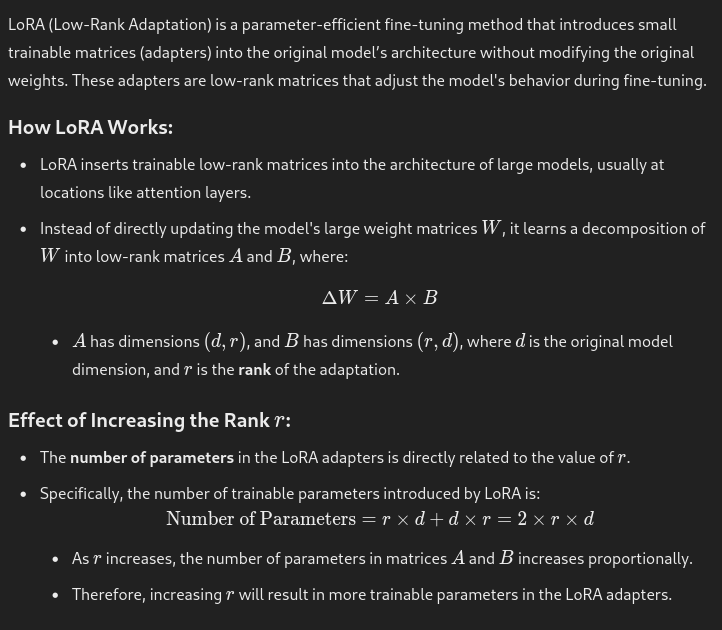